<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/Leo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [4]:
!git clone https://github.com/klaragerlei/GoatsOfAllTime.git
import GoatsOfAllTime.data_loader as dl
data_to_analyze = dl.load_data(alldat)

Cloning into 'GoatsOfAllTime'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 154 (delta 67), reused 18 (delta 7), pack-reused 0
Receiving objects: 100% (154/154), 10.71 MiB | 10.18 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Loading data...


In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
device

device(type='cpu')

Define network

In [30]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

  def predict(self, X_test):
    x0_test, x1_test = split_across_neurons(X_test)

    # the network outputs the single-neuron prediction and the latents
    z, y = self(x1_test)

    # our log-likelihood cost
    cost = Poisson_loss(z, x0_test).mean()
    #print('Cost:' + str(cost))
    rpred = z.detach().cpu().numpy()  # predicted output
    return rpred, cost

Prepare input

In [32]:
data_to_analyze = dl.load_data(alldat, brain_area='MOp', feature='face')
# dat['spks']: neurons by trials by time bins.
X = data_to_analyze.spikes.iloc[0].transpose(2,1,0)
# X: time bins by trials by neurons 
print(X.shape)
np.random.seed(42)
perm_idcs = np.random.permutation(X.shape[1])
train_idx = round(0.8 * X.shape[1])
X_train = X[:,perm_idcs[:train_idx]]
X_test = X[:,perm_idcs[train_idx:]]
print(X_train.shape)
print(X_test.shape)

Loading data...
(250, 342, 447)
(250, 274, 447)
(250, 68, 447)


In [33]:
def split_across_neurons(X):
  neuron_split_idx = X.shape[2] // 2
  x0 = torch.from_numpy(X_train[:,:,:neuron_split_idx]).to(device).float()
  x1 = torch.from_numpy(X_train[:,:,neuron_split_idx:neuron_split_idx*2]).to(device).float()
  return x0, x1

In [34]:
# todo x0 should be the spikes and x1 the behaviour
# x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
# x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()
neuron_split_idx = X.shape[2] // 2
x0 = torch.from_numpy(X_train[:,:,:neuron_split_idx]).to(device).float()
x1 = torch.from_numpy(X_train[:,:,neuron_split_idx:neuron_split_idx*2]).to(device).float()


NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# let's use 10 latent components
ncomp = 10

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))  # !!!!!!!!!!!

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

Train network

In [46]:
from scipy.stats import pearsonr
def corr3d(a, b):
  correlations = np.zeros(a.shape[:2])
  for i in np.arange(a.shape[-1]):
    for j in np.arange(b.shape[-1]):
      correlations[i,j], _ = pearsonr(a[i,j],b[i,j])
  return np.mean(correlations)

In [47]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    rpred_train = z.detach().cpu().numpy()  # predicted output
    rpred_test, cost_test = net.predict(X_test)
    correlation = corr3d(rpred_train, rpred_test)
    print(f'iteration {k}, cost {cost.item():.4f}, cost_test {cost_test.item():.4f}, correlation {correlation:.4f}')
  

  rpred = z.detach().cpu().numpy()  # predicted output

iteration 0, cost 0.0840, cost_test 0.0840, correlation 0.7177
iteration 100, cost 0.0835, cost_test 0.0835, correlation 0.7249
iteration 200, cost 0.0831, cost_test 0.0831, correlation 0.7221
iteration 300, cost 0.0828, cost_test 0.0828, correlation 0.7236
iteration 400, cost 0.0828, cost_test 0.0830, correlation 0.7119
iteration 500, cost 0.0824, cost_test 0.0824, correlation 0.7239
iteration 600, cost 0.0823, cost_test 0.0823, correlation 0.7242
iteration 700, cost 0.0822, cost_test 0.0822, correlation 0.7237
iteration 800, cost 0.0822, cost_test 0.0823, correlation 0.7145
iteration 900, cost 0.0821, cost_test 0.0821, correlation 0.7239


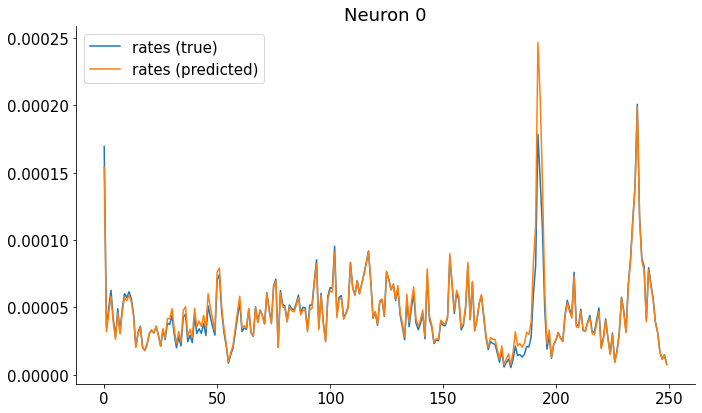

In [49]:
rpred = z.detach().cpu().numpy()
#rates = x0
trial_id = 29
neuron_id = 0
plt.figure(figsize=(10, 6))
plt.plot(rpred_train[:,trial_id, neuron_id])
plt.plot(rpred_test[:,trial_id, neuron_id])
#plt.plot(-.5 + X_train[:, trial_id, neuron_id]/4)

plt.legend(['rates (true)', 'rates (predicted)'])
plt.title(f'Neuron {neuron_id}')
plt.show()

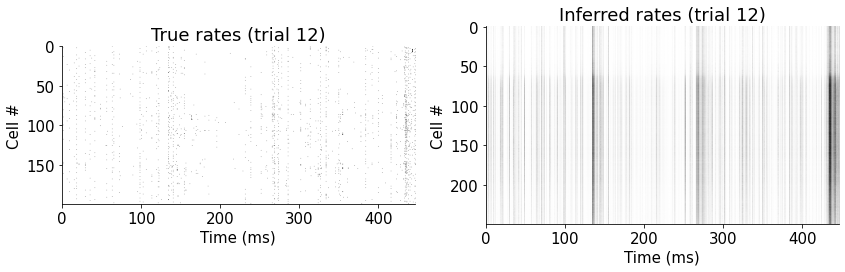

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, 12, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

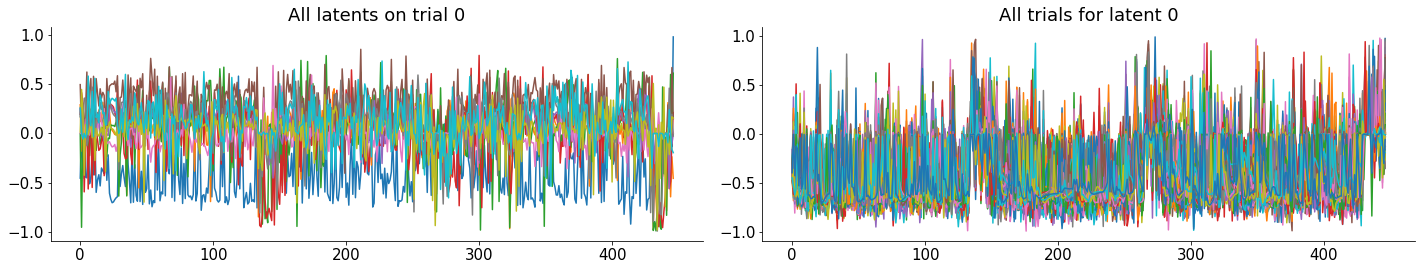

In [ ]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()